# Лабораторная работа №4: Кластеризация кредитоспособности клиентов немецкого банка

**Цель работы:**  
Исследовать методы кластеризации на примере данных о клиентах немецкого банка и выполнить группировку клиентов по сходным характеристикам.  
В работе используются методы K-means и DBSCAN, а также визуальные и численные критерии выбора числа кластеров и оценки качества разбиения.


In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    rand_score
)

from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True

# Загружаем данные
data_path = 'german_credit_data.csv'
df = pd.read_csv(data_path)

df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


## Описание датасета

Датасет содержит информацию о клиентах немецкого банка и их кредитах.  
Основные признаки:

- **Age** — возраст клиента;  
- **Sex** — пол;  
- **Job** — уровень занятости / должностной статус;  
- **Housing** — тип жилья (own, rent, free);  
- **Saving accounts** — состояние сберегательного счёта;  
- **Checking account** — состояние расчётного счёта;  
- **Credit amount** — сумма кредита;  
- **Duration** — срок кредита (в месяцах);  
- **Purpose** — цель кредита;  
- **Risk** — качественная оценка кредитоспособности клиента (good / bad).

В задаче кластеризации мы будем рассматривать признак *Risk* как дополнительный (внешний) критерий оценки кластеров, но при формировании самих кластеров он использоваться не будет.


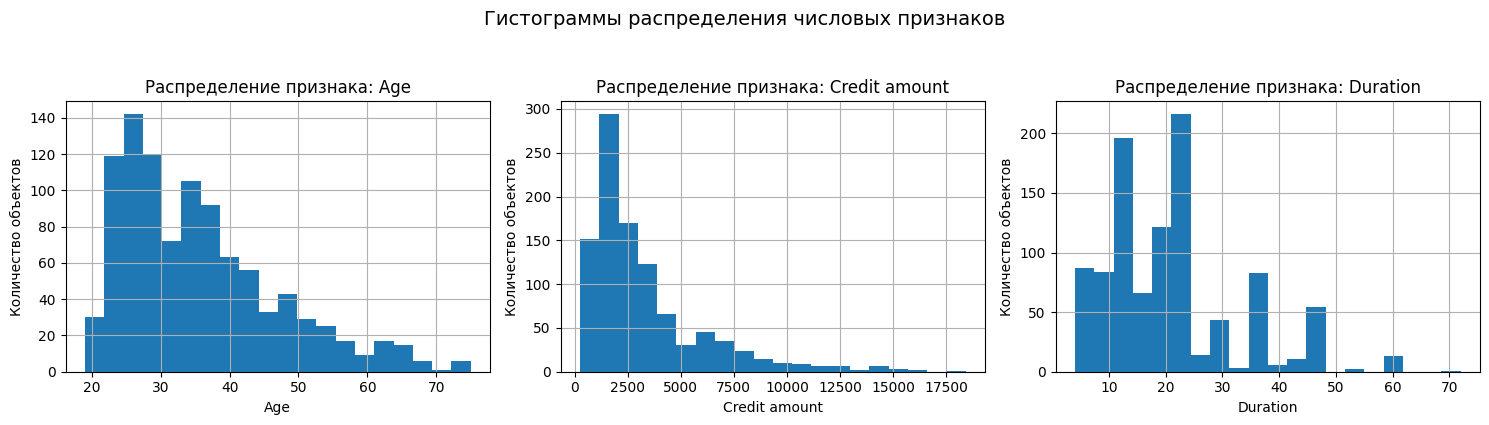

In [2]:
import matplotlib.pyplot as plt
import numpy as np


numeric_features = ['Age', 'Credit amount', 'Duration']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(15, 4))

for ax, col in zip(axes, numeric_features):
    ax.hist(df[col].dropna(), bins=20)
    ax.set_title(f'Распределение признака: {col}')
    ax.set_xlabel(col)                 # X-подпись
    ax.set_ylabel('Количество объектов') # Y-подпись

fig.suptitle('Гистограммы распределения числовых признаков', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


**Вывод**  
По гистограммам видно, что распределения числовых признаков далеки от идеального нормального: встречаются асимметрия и «длинные хвосты». Это типично для финансовых данных (например, для суммы кредитов). Поэтому перед кластеризацией важно привести признаки к одному масштабу (стандартизация/нормализация), иначе признаки с большими значениями будут доминировать при расчёте расстояний.


Далее построим матрицу корреляций для более визуального представления.

**ВАЖНО:**


Мы строим матрицу ТОЛЬКО для числовых признаков, категориальные не в счёт (там нужно one-hot-encoding  и всякое такое)

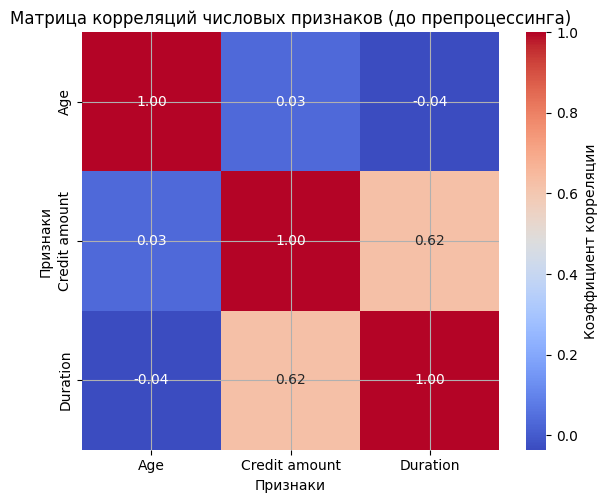

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[numeric_features].corr(method='pearson')

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={"label": "Коэффициент корреляции"})
plt.title("Матрица корреляций числовых признаков (до препроцессинга)")
plt.xlabel("Признаки")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()

**Вывод по матрице корреляций**  
Тепловая карта показывает степень линейной связи между числовыми признаками. Сильные по модулю корреляции указывают на возможную избыточность признаков, а слабые — на относительную независимость. В задачах кластеризации высокая корреляция может приводить к «дублированию информации», поэтому такой анализ полезен перед масштабированием и выбором набора признаков.


### **Визуализация распределений признаков**

Построим гистограммы для основных числовых признаков и оценим наличие выбросов и отклонение от нормального распределения.

### **Матрица диаграмм рассеивания**

Для предварительной визуальной оценки структуры данных построим матрицу диаграмм рассеивания для числовых признаков.

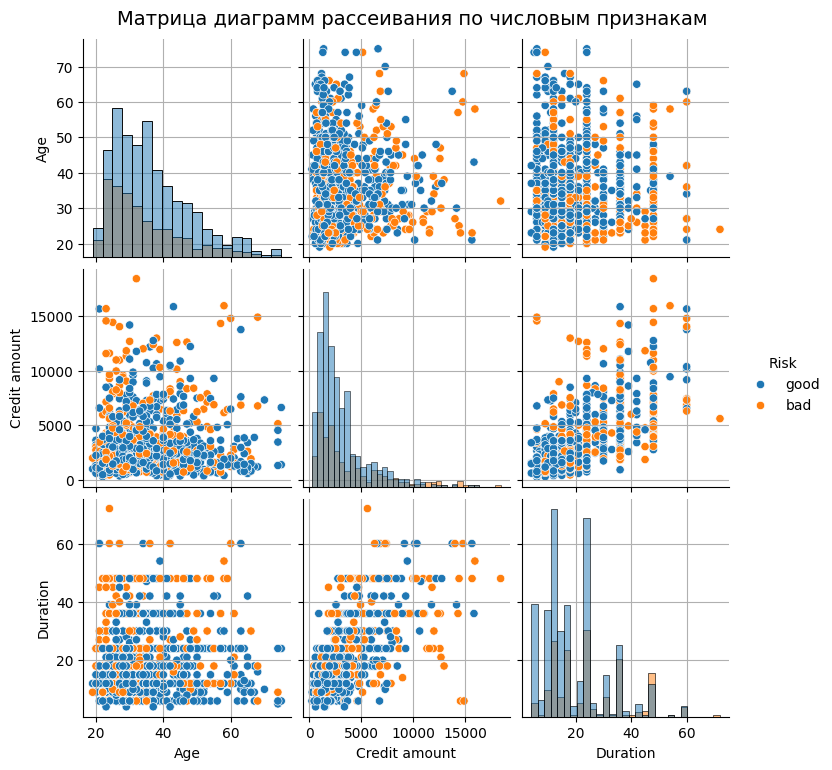

In [4]:
g = sns.pairplot(df[numeric_features + ['Risk']], hue='Risk', diag_kind='hist')
g.fig.suptitle('Матрица диаграмм рассеивания по числовым признакам', y=1.02, fontsize=14)
plt.show()

**На основе матрицы диаграмм рассеивания можно сделать вывод, что:**

Количество кластеров - 2;
Плотность объектов - высокая (в связи с возрастами и сроком выплат кредита)


Лучше всего для данного датасета подойдут методы: K-means (базовый метод задачи кластеризации), Иерархическая кластеризация (удобно будет использовать дивизивную, т.к. плотность объектов большая), DBSCAN (по аналогии с иерархией, большая плотность объектов, засчёт чего данный метод будет более эффективен).

**Проводим анализ выбросов**

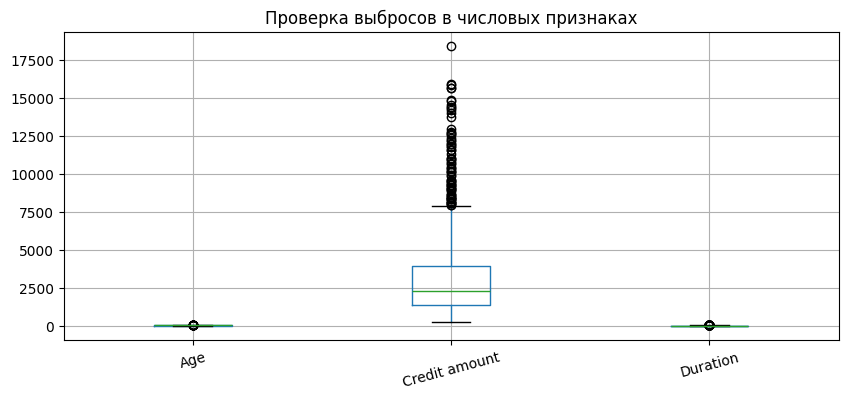

,Колонка,Частота выбросов(IQR)
0,Age,0.023
1,Credit amount,0.072
2,Duration,0.070


In [15]:
import numpy as np
import matplotlib.pyplot as plt

numeric_features = ['Age', 'Credit amount', 'Duration']

# Boxplot
plt.figure(figsize=(10, 4))
df[numeric_features].boxplot()
plt.title('Проверка выбросов в числовых признаках')
plt.xticks(rotation=15)
plt.show()

# IQR-оценка доли выбросов
outlier_stats = []
for col in numeric_features:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = ((df[col] < lower) | (df[col] > upper)).mean()
    outlier_stats.append([col, outliers])

outlier_df = pd.DataFrame(outlier_stats, columns=['Колонка','Частота выбросов(IQR)'])
outlier_df


**Вывод по выбросам**

Большое количество выбросов наблюдается в признаке "Сумма кредита". Это объясняется тем, что некоторые клиенты (в особенности среднего возраста, с хорошей зарплатой и своим жильём) сильно не ограничены в средствах и могут брать более большие суммы кредита, что и объясняет выбрросы.

## Предобработка данных и масштабирование

Для корректной работы алгоритмов кластеризации, основанных на расстояниях (особенно K-means и иерархической кластеризации с евклидовым расстоянием), необходимо привести числовые признаки к одному масштабу.

Мы будем использовать **StandardScaler**, который вычитает среднее и делит на стандартное отклонение.  
Категориальные признаки закодируем методом **One-Hot Encoding**.

In [6]:
# Удаляем технический столбец
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Целевая переменная для внешней оценки (использоваться в кластеризации не будет)
y_raw = df['Risk']
y = y_raw.map({'good': 0, 'bad': 1})

X = df.drop(columns=['Risk'])

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print('Числовые признаки:', numeric_cols)
print('Категориальные признаки:', categorical_cols)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X_scaled = preprocessor.fit_transform(X)

print('Форма матрицы признаков после кодирования и масштабирования:', X_scaled.shape)

Числовые признаки: ['Age', 'Job', 'Credit amount', 'Duration']
Категориальные признаки: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
Форма матрицы признаков после кодирования и масштабирования: (1000, 26)


Проведём информационную значимость признаков

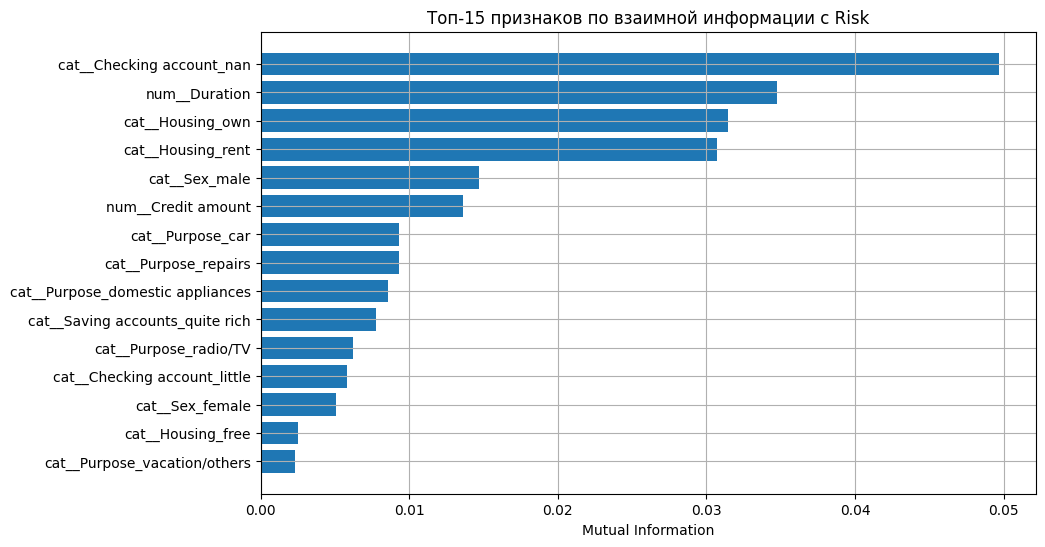

,Feature,MutualInfo(Risk)
17,cat__Checking account_nan,0.049673
3,num__Duration,0.034731
7,cat__Housing_own,0.031429
8,cat__Housing_rent,0.030695
5,cat__Sex_male,0.014718
2,num__Credit amount,0.013607
19,cat__Purpose_car,0.009334
24,cat__Purpose_repairs,0.009301
20,cat__Purpose_domestic appliances,0.008569
11,cat__Saving accounts_quite rich,0.007790


In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Используем уже подготовленные X (без Risk) и y_risk (0/1)
y_risk = df['Risk'].map({'good': 0, 'bad': 1})

X_tmp = df.drop(columns=['Risk'])

X_encoded = preprocessor.fit_transform(X_tmp)

mi = mutual_info_classif(
    X_encoded.toarray() if hasattr(X_encoded, "toarray") else X_encoded,
    y_risk,
    random_state=RANDOM_STATE
)

feature_names = preprocessor.get_feature_names_out()
mi_df = pd.DataFrame({'Feature': feature_names, 'MutualInfo(Risk)': mi}).sort_values('MutualInfo(Risk)', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(mi_df.head(15)['Feature'][::-1], mi_df.head(15)['MutualInfo(Risk)'][::-1])
plt.title('Топ-15 признаков по взаимной информации с Risk')
plt.xlabel('Mutual Information')
plt.show()

mi_df.head(15)


**Вывод по информационной значимости признаков**  
На основании расчёта взаимной информации между признаками и целевой переменной *Risk* можно сделать вывод, что наибольший вклад в различие кредитоспособности наиболее информативным признаком оказался тип расчётного счёта клиента, что указывает на важность финансового поведения и уровня ликвидности при оценке кредитного риска. Существенную значимость также демонстрируют срок кредита (*Duration*), а также признаки, связанные с жилищными условиями клиента (аренда или владение жильём).

Числовые признаки, такие как сумма кредита (*Credit amount*) и срок кредитования, обладают умеренной информативностью, что подтверждает их влияние на вероятность возврата кредита, однако не является доминирующим по сравнению с качественными характеристиками клиента. Признаки, связанные с целью кредита, а также отдельные демографические параметры, имеют относительно низкие значения взаимной информации и вносят меньший вклад в объяснение кредитного риска.

В целом полученные результаты подтверждают, что кредитоспособность клиентов определяется совокупностью нескольких факторов, а не одним доминирующим признаком. Это обосновывает применение многомерных методов анализа, в том числе кластеризации, для выявления групп клиентов с различными профилями кредитного риска.


## Метод K-means: подбор числа кластеров

Для выбора количества кластеров k используем метод локтя и силуэтный анализ.

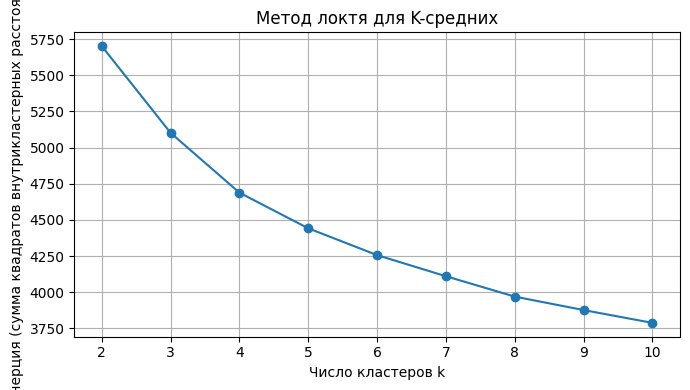

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

k_values = range(2, 11)
best_k = 3
inertias = []

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

# Финальная модель K-means
kmeans = KMeans(
    n_clusters=best_k,
    n_init=10,
    random_state=RANDOM_STATE
)

kmeans_labels = kmeans.fit_predict(X_scaled)


plt.figure(figsize=(7, 4))
plt.plot(list(k_values), inertias, marker='o')
plt.title('Метод локтя для K-средних')
plt.xlabel('Число кластеров k')
plt.ylabel('Инерция (сумма квадратов внутрикластерных расстояний)')
plt.grid(True)
plt.tight_layout()
plt.show()


**Вывод по методу локтя**  
При увеличении числа кластеров значение инерции уменьшается, так как кластеры становятся «уже». Оптимальное k обычно выбирают в точке перегиба («локтя»), где дальнейшее увеличение k даёт уже небольшое улучшение. Это значение k можно дополнительно подтвердить силуэтным анализом. Предварительно можно сказать, что оптимлаьное число кластеров - k=2 


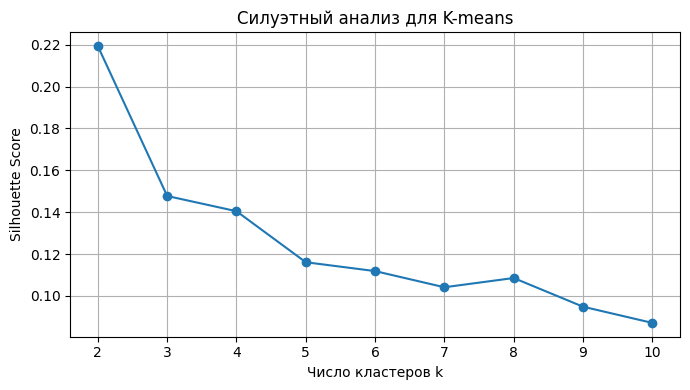

2

In [9]:
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.figure(figsize=(7, 4))
plt.plot(list(k_values), sil_scores, marker='o')
plt.title('Силуэтный анализ для K-means')
plt.xlabel('Число кластеров k')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

best_k = list(k_values)[int(np.argmax(sil_scores))]
best_k


**Вывод по силуэтному анализу**  
Silhouette Score отражает, насколько объекты ближе к своему кластеру, чем к соседним. Чем выше значение, тем более «компактны» и «разделимы» кластеры. Максимум на графике указывает на наиболее удачное число кластеров k для K-средних (по внутренней метрике).


## **DBSCAN**

В связи с тем, что предварительный анализ показал высокую плотность между объектами, было принято решение использовать метод DBSCAN, который очень хорошо показывает себя в таких ситуациях.

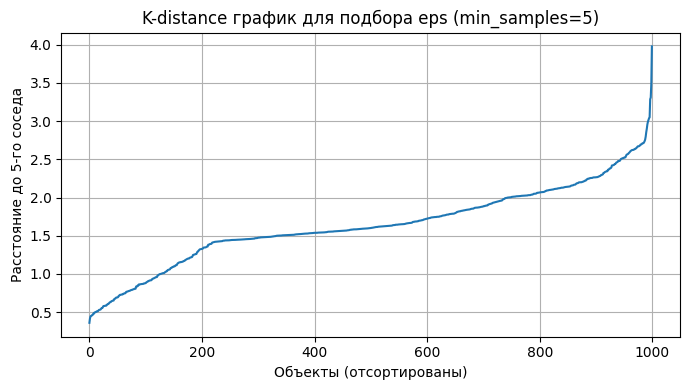

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

min_samples = 5  # можно варьировать

nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)

# берём расстояние до k-го соседа
k_dist = np.sort(distances[:, -1])

plt.figure(figsize=(7, 4))
plt.plot(k_dist)
plt.title(f'K-distance график для подбора eps (min_samples={min_samples})')
plt.xlabel('Объекты (отсортированы)')
plt.ylabel(f'Расстояние до {min_samples}-го соседа')
plt.grid(True)
plt.tight_layout()
plt.show()


**Вывод по k-distance графику**  
На графике обычно ищут резкий рост расстояний среди объектов. Значение расстояния в точке излома можно взять как ориентир для параметра `eps` в DBSCAN: до излома точки лежат в плотных областях, после — начинаются разреженные области. (eps - 1.5)


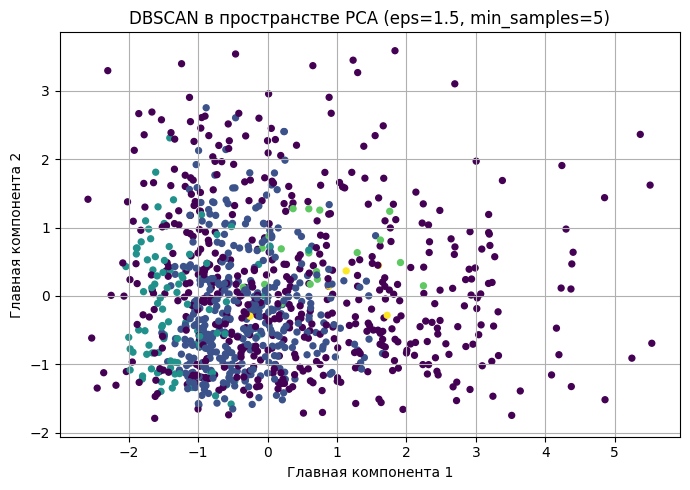

(4, np.int64(511))

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Выбираем eps на основе k-distance
eps = 1.5
db = DBSCAN(eps=eps, min_samples=min_samples)

db_labels = db.fit_predict(X_scaled)

# PCA для визуализации
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db_labels, s=18)
plt.title(f'DBSCAN в пространстве PCA (eps={eps}, min_samples={min_samples})')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.tight_layout()
plt.show()

# Сколько кластеров и шум
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = np.sum(db_labels == -1)
n_clusters, n_noise


**Вывод по результатам DBSCAN**  
DBSCAN выделяет кластеры как области повышенной плотности и дополнительно помечает часть объектов как шум. На проекции графика видно, как алгоритм группирует точки без явного задания числа кластеров. Если шумовых точек слишком много, обычно стоит уменьшить `eps` или увеличить `min_samples`; если почти все точки в одном кластере — чаще всего нужно увеличить `eps` или уменьшить `min_samples`.


**Метрики качества для DBSCAN и KMeans**

Для DBSCAN Силуэта/CH корректны только если кластеров больше 1 и есть не только шум. Поэтому добавим защиту.

In [17]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

def safe_internal_metrics(X, labels):
    unique = set(labels)
    # если один кластер или все шум -1 -> метрики не считаем
    if len(unique - {-1}) < 2:
        return np.nan, np.nan
    
    # для silhouette убираем шумовые точки
    mask = labels != -1
    if mask.sum() < 2 or len(set(labels[mask])) < 2:
        return np.nan, np.nan
    
    sil = silhouette_score(X[mask], labels[mask])
    ch = calinski_harabasz_score(X[mask], labels[mask])
    return sil, ch

sil_km = silhouette_score(X_scaled, kmeans_labels)
ch_km = calinski_harabasz_score(X_scaled, kmeans_labels)

sil_db, ch_db = safe_internal_metrics(X_scaled, db_labels)

metrics_df = pd.DataFrame([
    {"Метод": "K-means", "Силуэт": sil_km, "Калинский-Карабас": ch_km},
    {"Метод": "DBSCAN", "Силуэт": sil_db, "Калинский-Карабас": ch_db},
])
metrics_df


,Метод,Силуэт,Калинский-Карабас
0,K-means,0.147713,177.399982
1,DBSCAN,0.104457,30.152735


**Вывод по внутренним метрикам**  
Значение силуэта и индекс Калинского-Карабаса отражают качество разбиения с точки зрения компактности и разделимости кластеров. Для DBSCAN метрики считаются корректно только при наличии как минимум двух непустых кластеров.

**Исследование влияния параметров DBSCAN (eps и/или min_samples)**

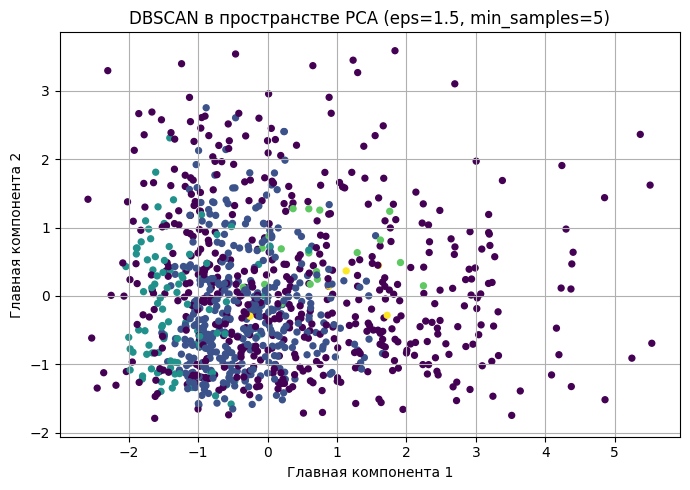

In [18]:
eps_values = np.linspace(0.3, 1.5, 7)
stats = []

for e in eps_values:
    db = DBSCAN(eps=float(e), min_samples=min_samples)
    labels = db.fit_predict(X_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)

    sil, ch = safe_internal_metrics(X_scaled, labels)
    stats.append([float(e), n_clusters, int(n_noise), sil])

stats_df = pd.DataFrame(stats, columns=["eps", "n_clusters", "n_noise", "silhouette"])
stats_df

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db_labels, s=18)
plt.title(f'DBSCAN в пространстве PCA (eps={eps}, min_samples={min_samples})')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.tight_layout()
plt.show()



**Вывод по влиянию параметра eps**  
При изменении eps меняется плотностной порог объединения точек: при слишком малом eps (0,8) возрастает доля шума и число кластеров может стать слишком большим; при слишком большом eps (7 к примеру) кластеры сливаются и алгоритм может выделить один крупный кластер.

**Отдельный графики KMeans и DBSCAN в PCA**

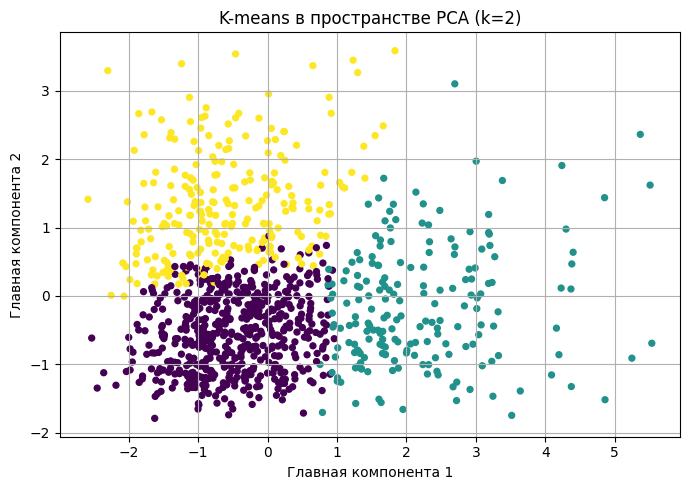

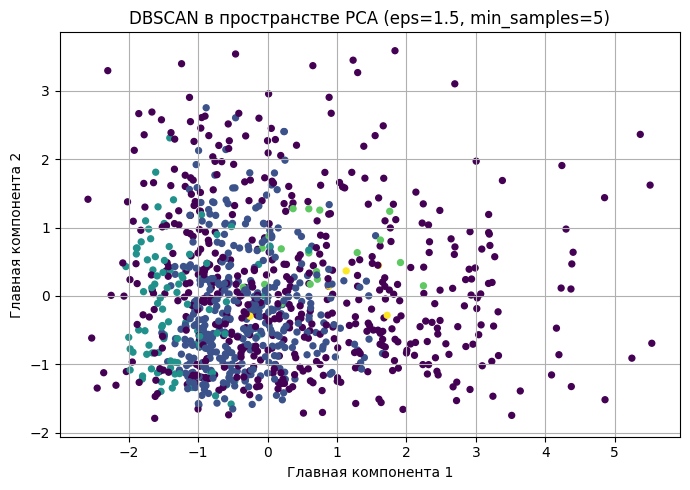

In [19]:

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, s=18)
plt.title(f'K-means в пространстве PCA (k={best_k})')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db_labels, s=18)
plt.title(f'DBSCAN в пространстве PCA (eps={eps}, min_samples={min_samples})')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.tight_layout()
plt.show()


**Вывод по сравнению визуализаций**  
На проекции PCA можно сравнить характер разбиения: K-means формирует кластеры вокруг центров (и всегда создаёт ровно k групп), а DBSCAN выделяет кластеры как плотные области и может оставлять часть объектов как шум. Для данных кредитной тематики DBSCAN может быть полезен тем, что отдельно выявляет «нетипичных» клиентов (шумовые точки), которые потенциально соответствуют выбросам/аномалиям.


## Заключение

В лабораторной работе была проведена кластеризация клиентов немецкого банка на основе их социально-демографических и финансовых характеристик.  
Были реализованы два метода кластеризации — K-means и DBSCAN, а также выполнен подбор числа кластеров с использованием метода локтя и силуэтного анализа.

Для оценки качества кластеризации использовались внутренние метрики, а также внешние метрики, основанные на сравнении кластеров с известной меткой кредитоспособности.  
Сравнение результатов показало, что оба метода выделяют сходные группы клиентов, однако численные значения метрик и визуальный анализ кластеров позволяют сделать вывод о различиях в форме и компактности полученных групп.

Интерпретация центров кластеров K-means показала, что выделенные группы соответствуют различным типам клиентов: условно более надёжные (good) и более рискованные (bad) с различиями в возрасте, сумме и сроке кредита, а также типах счетов и целей кредитования.  
В целом методы кластеризации демонстрируют применимость для предварительного сегментирования клиентов и могут служить основой для более сложных моделей кредитного скоринга и таргетированных продуктов банка.
